In [137]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [115]:
# Load the image and convert it to grayscale.
image = cv2.imread('resources/barcode-bottle1.png')
# image = cv2.imread('resources/barcode2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# compute the Scharr gradient magnitude representation of the images in both the x and y direction.

# Find vertical lines (x-axis intensity change when y = 0).
gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)

# Find horizontal lines (y-axis intensity change when x = 0).
gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)

# Converts negative values to absolute values |x|.
gradient = cv2.convertScaleAbs(gradient)

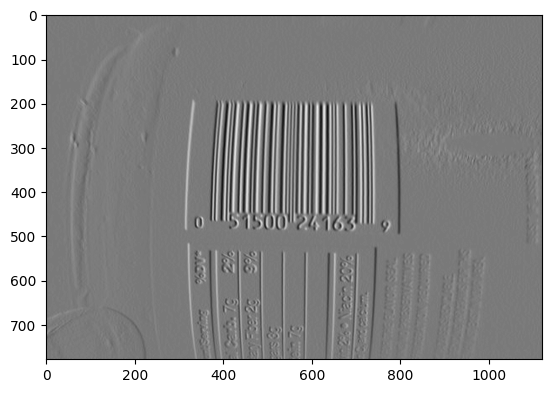

In [116]:
plt.imshow(gradX, cmap='gray')

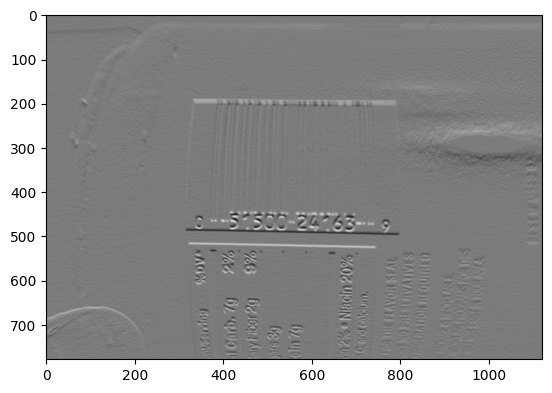

In [117]:
plt.imshow(gradY, cmap='gray')

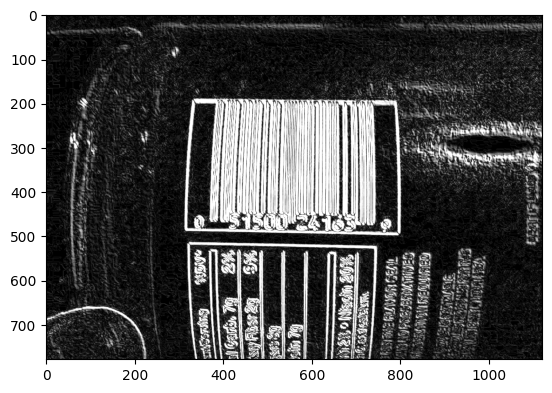

In [118]:
plt.imshow(gradient, cmap='gray')

In [119]:
# blur and threshold the image
blurred = cv2.blur(gradient, (3, 3))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

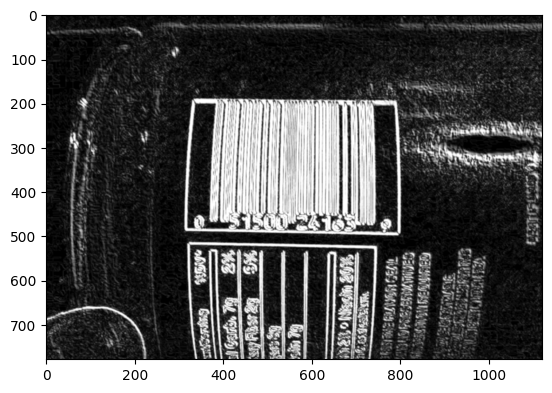

In [120]:
plt.imshow(blurred, cmap='gray')

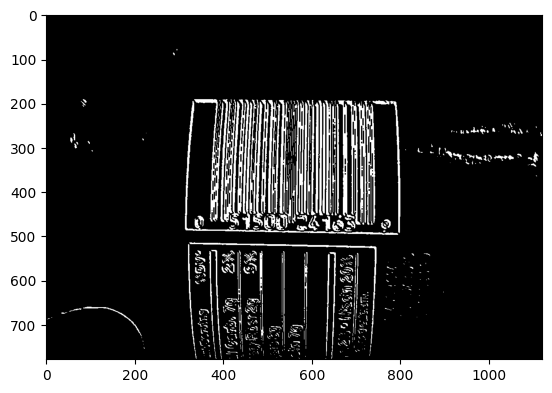

In [121]:
plt.imshow(thresh, cmap='gray')

In [122]:
# construct a closing kernel and apply it to the thresholded image
se = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, se)

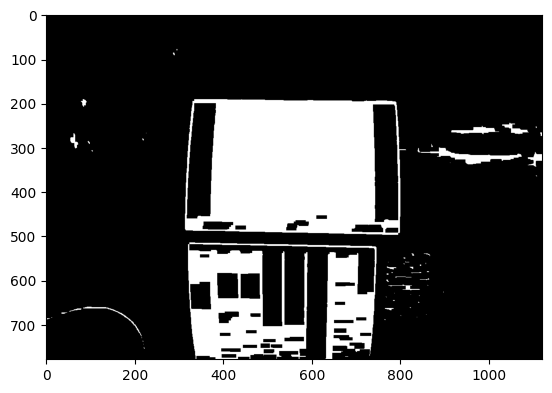

In [123]:
plt.imshow(closed, cmap='gray')

In [133]:
# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations=4)
closed = cv2.dilate(closed, None, iterations=4)

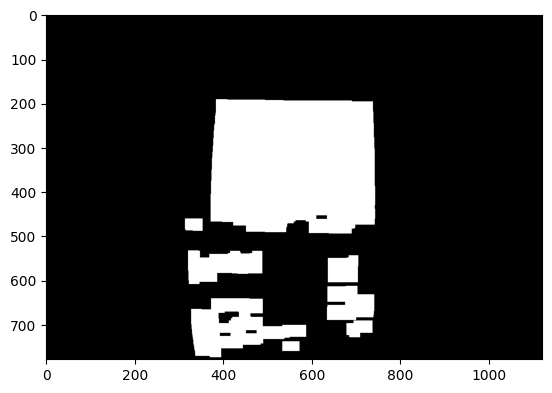

In [134]:
plt.imshow(closed, cmap='gray')

In [136]:
# find the contours in the thresholded image, then sort the contours by their area, keeping only the largest one
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.intp(cv2.boxPoints(rect))
# draw a bounding box arounded the detected barcode and display the
# image
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
# cv2.imshow("Image", image)
# cv2.waitKey(0)

array([[[ 30,  37,  37],
        [ 30,  36,  36],
        [ 31,  36,  37],
        ...,
        [ 20,  19,  24],
        [ 19,  19,  23],
        [ 19,  19,  22]],

       [[ 30,  37,  38],
        [ 30,  36,  37],
        [ 31,  37,  37],
        ...,
        [ 20,  19,  24],
        [ 19,  19,  22],
        [ 19,  19,  22]],

       [[ 31,  37,  38],
        [ 31,  37,  37],
        [ 31,  37,  37],
        ...,
        [ 20,  20,  24],
        [ 19,  19,  22],
        [ 19,  19,  22]],

       ...,

       [[ 67,  71, 106],
        [ 67,  71, 105],
        [ 69,  71, 106],
        ...,
        [ 15,   9,  63],
        [ 14,   9,  62],
        [ 14,   8,  62]],

       [[ 67,  72, 105],
        [ 65,  70, 103],
        [ 69,  73, 106],
        ...,
        [ 16,   9,  61],
        [ 15,   8,  60],
        [ 14,   7,  60]],

       [[ 68,  73, 104],
        [ 66,  71, 103],
        [ 69,  74, 107],
        ...,
        [ 17,  10,  60],
        [ 16,  10,  59],
        [ 15,   9,  59]]

In [127]:
c

array([[[384, 192]],

       [[384, 222]],

       [[383, 223]],

       [[383, 228]],

       [[382, 229]],

       [[382, 246]],

       [[381, 247]],

       [[381, 249]],

       [[380, 250]],

       [[380, 262]],

       [[379, 263]],

       [[379, 279]],

       [[378, 280]],

       [[378, 296]],

       [[377, 297]],

       [[377, 310]],

       [[376, 311]],

       [[376, 323]],

       [[375, 324]],

       [[375, 350]],

       [[374, 351]],

       [[374, 375]],

       [[373, 376]],

       [[373, 405]],

       [[372, 406]],

       [[372, 467]],

       [[397, 467]],

       [[398, 468]],

       [[422, 468]],

       [[423, 469]],

       [[423, 476]],

       [[451, 476]],

       [[452, 477]],

       [[452, 490]],

       [[494, 490]],

       [[495, 491]],

       [[542, 491]],

       [[542, 481]],

       [[544, 479]],

       [[544, 474]],

       [[545, 473]],

       [[545, 472]],

       [[546, 471]],

       [[559, 471]],

       [[559, 468]],

       [[5

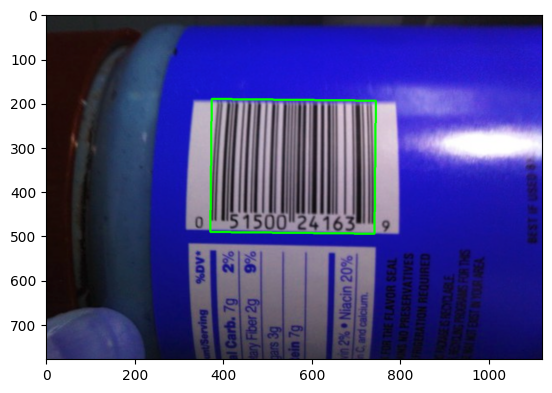

In [128]:
plt.imshow(image)

In [129]:
# plt.imshow(box)
[X, Y, W, H] = cv2.boundingRect(box)

In [130]:
cropped = image[Y:Y + H, X:X + W]

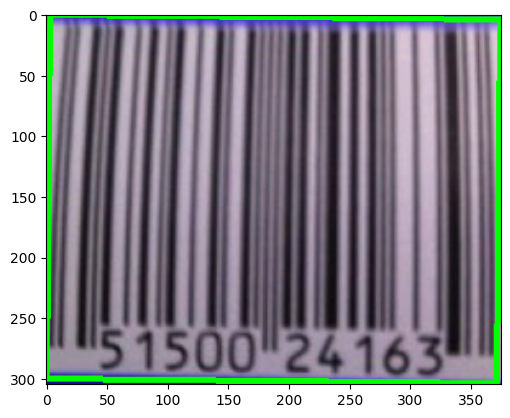

In [131]:
# plt.show(cropped)
plt.imshow(cropped)
# image.shape